## Gather the paths from the 2 datasets (Shenzhen Lung Image dataset + Shenzhen Lung Mask dataset)

In [1]:
from glob import glob
import os
xrays_path = '../input/tuberculosis-chest-xrays-shenzhen/images/images'
masks_path = '../input/shcxr-lung-mask/mask'

cxr_paths = glob(os.path.join('..', 'input', 'shcxr-lung-mask',
                              'mask', '*.png'))
image_pair_paths = []
for mask_path in cxr_paths:
    mask_file_name = os.path.basename(mask_path)
    xray_file_name = mask_file_name.replace('_mask', '')
    xray_file_path = os.path.join(xrays_path, xray_file_name)
    if os.path.exists(xray_file_path):
        paths_tuple = (xray_file_path, mask_path)
        image_pair_paths.append(paths_tuple)

# Read Xray + Mask data from data sources & create numpy data volumes


In [2]:
from cv2 import imread, createCLAHE # read and equalize images
from skimage.io import imread as imread_raw
from skimage.transform import resize

OUT_DIM = (512, 512)

def imread(in_path, apply_clahe = False):
    img_data = imread_raw(in_path)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.uint8)
    if apply_clahe:
        clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
        n_img = clahe_tool.apply(n_img)
    return np.expand_dims(n_img, -1)

In [3]:
from tqdm import tqdm
# from cv2 import imread, createCLAHE # read and equalize images
import numpy as np

load_from_file = False

if load_from_file:
    img_vol = np.load('img_vol.npy')
    seg_vol = np.load('seg_vol.npy')
else:
    img_vol, seg_vol = [], []
    for img_path, s_path in tqdm(image_pair_paths):
        img_vol_temp = imread(img_path)

        if img_vol_temp.shape == (512, 512, 3, 1): # some of the images have 3 channels of ident info, so just take 1st channel
            img_vol_temp = img_vol_temp[:, :, 0, :] # just take 1 channel

        assert img_vol_temp.shape == (512, 512, 1)
        img_vol += [img_vol_temp]    

        seg_vol_temp = imread(s_path)
        if seg_vol_temp.shape == (512, 512, 3, 1): # some of the images have 3 channels of ident info, so just take 1st channel
            seg_vol_temp = seg_vol_temp[:, :, 0, :] # just take 1 channel

        assert seg_vol_temp.shape == (512, 512, 1)
        seg_vol += [seg_vol_temp]

    img_vol = np.stack(img_vol,0)
    seg_vol = np.stack(seg_vol,0)
    
    np.save('img_vol.npy', img_vol)
    np.save('seg_vol.npy', seg_vol)
    
    print('Images', img_vol.shape, 'Segmentations', seg_vol.shape)

100%|██████████| 566/566 [07:20<00:00,  1.29it/s]


Images (566, 512, 512, 1) Segmentations (566, 512, 512, 1)


## Check the image/mask data for anything odd

Validation Xrays (566, 512, 512, 1) 155.52334737609218 255
Seg (566, 512, 512, 1) 255 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 2

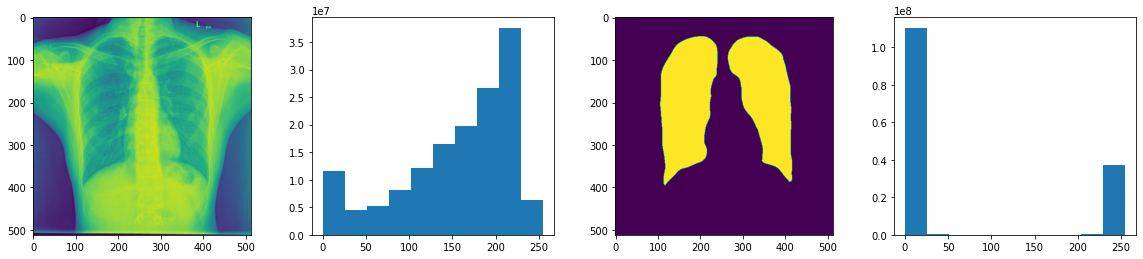

In [4]:
import matplotlib.pyplot as plt

print('Validation Xrays', img_vol.shape, img_vol.mean(), img_vol.max())
print('Seg', seg_vol.shape, seg_vol.max(), np.unique(seg_vol.ravel()))

fig, (ax1, ax1hist, ax2, ax2hist) = plt.subplots(1, 4, figsize = (20, 4))
ax1.imshow(img_vol[0, :, :, 0])
ax1hist.hist(img_vol.ravel())
ax2.imshow(seg_vol[0, :, :, 0]>0.5)
ax2hist.hist(seg_vol.ravel());

The mask data appears to be a bit odd for some cases, but its mostly 0's and 256.
it appears that the boundary of the mask has none 0/256 values to note the edge.

## Create Unet Model Function

In [5]:
from keras.models import Model
from keras import layers

from keras.layers import Conv2D, Activation, Input, UpSampling2D, concatenate, BatchNormalization
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
def c2(x_in, nf, strides=1):
    x_out = Conv2D(nf, kernel_size=3, padding='same',
                   kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = LeakyReLU(0.2)(x_out)
    return x_out
def unet_enc(vol_size, enc_nf, pre_filter = 8):
    src = Input(shape=vol_size + (1,), name = 'EncoderInput')
    # down-sample path.
    x_in = BatchNormalization(name = 'NormalizeInput')(src)
    x_in = c2(x_in, pre_filter, 1)
    x0 = c2(x_in, enc_nf[0], 2)  
    x1 = c2(x0, enc_nf[1], 2)  
    x2 = c2(x1, enc_nf[2], 2)  
    x3 = c2(x2, enc_nf[3], 2) 
    return Model(inputs = [src], 
                outputs = [x_in, x0, x1, x2, x3],
                name = 'UnetEncoder')

def unet(vol_size, enc_nf, dec_nf, full_size=True, edge_crop=48):
    """
    unet network for voxelmorph 
    Args:
        vol_size: volume size. e.g. (256, 256, 256)
        enc_nf: encoder filters. right now it needs to be to 1x4.
            e.g. [16,32,32,32]
            TODO: make this flexible.
        dec_nf: encoder filters. right now it's forced to be 1x7.
            e.g. [32,32,32,32,8,8,3]
            TODO: make this flexible.
        full_size
    """

    # inputs
    raw_src = Input(shape=vol_size + (1,), name = 'ImageInput')
    src = layers.GaussianNoise(0.25)(raw_src)
    enc_model = unet_enc(vol_size, enc_nf)
    # run the same encoder on the source and the target and concatenate the output at each level
    x_in, x0, x1, x2, x3 = [s_enc for s_enc in enc_model(src)]

    x = c2(x3, dec_nf[0])
    x = UpSampling2D()(x)
    x = concatenate([x, x2])
    x = c2(x, dec_nf[1])
    x = UpSampling2D()(x)
    x = concatenate([x, x1])
    x = c2(x, dec_nf[2])
    x = UpSampling2D()(x)
    x = concatenate([x, x0])
    x = c2(x, dec_nf[3])
    x = c2(x, dec_nf[4])
    x = UpSampling2D()(x)
    x = concatenate([x, x_in])
    x = c2(x, dec_nf[5])

    # transform the results into a flow.
    y_seg = Conv2D(1, kernel_size=3, padding='same', name='lungs', activation='sigmoid')(x)
    y_seg = layers.Cropping2D((edge_crop, edge_crop))(y_seg)
    y_seg = layers.ZeroPadding2D((edge_crop, edge_crop))(y_seg)
    # prepare model
    model = Model(inputs=[raw_src], outputs=[y_seg])
    return model

## Create Instance of the Unet Model

In [6]:
nf_enc=[16,32,32,32]
nf_dec=[32,32,32,32,32,16,16,2]

net = unet(OUT_DIM, nf_enc, nf_dec)

2023-02-20 12:56:53.902781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 12:56:54.002461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 12:56:54.003268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 12:56:54.005367: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Load the model weights from the h5 saved from the template notebook provided

https://www.kaggle.com/code/kmader/training-u-net-on-tb-images-to-segment-lungs

In [7]:
net.load_weights('/kaggle/input/training-u-net-on-tb-images-to-segment-lungs/full_model.h5')

## Data Loader

only needed for the show_examples function

In [8]:
from keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator()

def gen_augmented_pairs(in_vol, in_seg, batch_size = 16):
    while True:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_vol = image_gen.flow(in_vol, batch_size = batch_size, seed = seed)
        g_seg = image_gen.flow(in_seg, batch_size = batch_size, seed = seed)
        for i_vol, i_seg in zip(g_vol, g_seg):
            yield i_vol, i_seg
            
val_gen = gen_augmented_pairs((img_vol-127.0)/127.0, (seg_vol>127).astype(np.float32), batch_size = 16)            

## Metric Func for use in Evaluation

In [9]:
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.losses import binary_crossentropy

reg_param = 1.0
lr = 2e-4
dice_bce_param = 0.0
use_dice = True

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return dice_bce_param*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

net.compile(optimizer=Adam(learning_rate=lr), 
              loss=[dice_p_bce], 
           metrics = [true_positive_rate, 'binary_accuracy'])

## Evaluation

In [10]:
results = net.evaluate((img_vol-127)/127.0, (seg_vol > 127).astype(float), batch_size=16)

2023-02-20 12:56:59.632476: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 593494016 exceeds 10% of free system memory.
2023-02-20 12:57:00.693804: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 593494016 exceeds 10% of free system memory.
2023-02-20 12:57:01.400207: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 593494016 exceeds 10% of free system memory.
2023-02-20 12:57:01.930248: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 593494016 exceeds 10% of free system memory.
2023-02-20 12:57:02.562320: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-20 12:57:04.004555: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


36/36 [==============================] - 10s 65ms/step - loss: -0.2830 - true_positive_rate: 0.1868 - binary_accuracy: 0.7626


Using a new, never seen dataset, our model performs worse than the montgomery results (85%+ accuracy).

Here we only achieved 76%.

is 76% still a decent result? Lets check the baseline by testing to see, whats happens if our model just prediced no lungs at all (i.e. 0 values for the predicted mask/seg)

In [11]:
seg_vol_temp = (seg_vol > 127).astype(int)
naive_accuracy = 1-seg_vol_temp.sum()/seg_vol_temp.size
print(f'Naive Accuracy/Benchmark Accuracy: {naive_accuracy*100:0.2f}%')

Naive Accuracy/Benchmark Accuracy: 74.74%


# The naive model that segments everything as 'Not Lung' would achieve 74.47% since 74.47% of the area of the images is not lung

# Examples of the poor performance

0.8295882
0.7866211


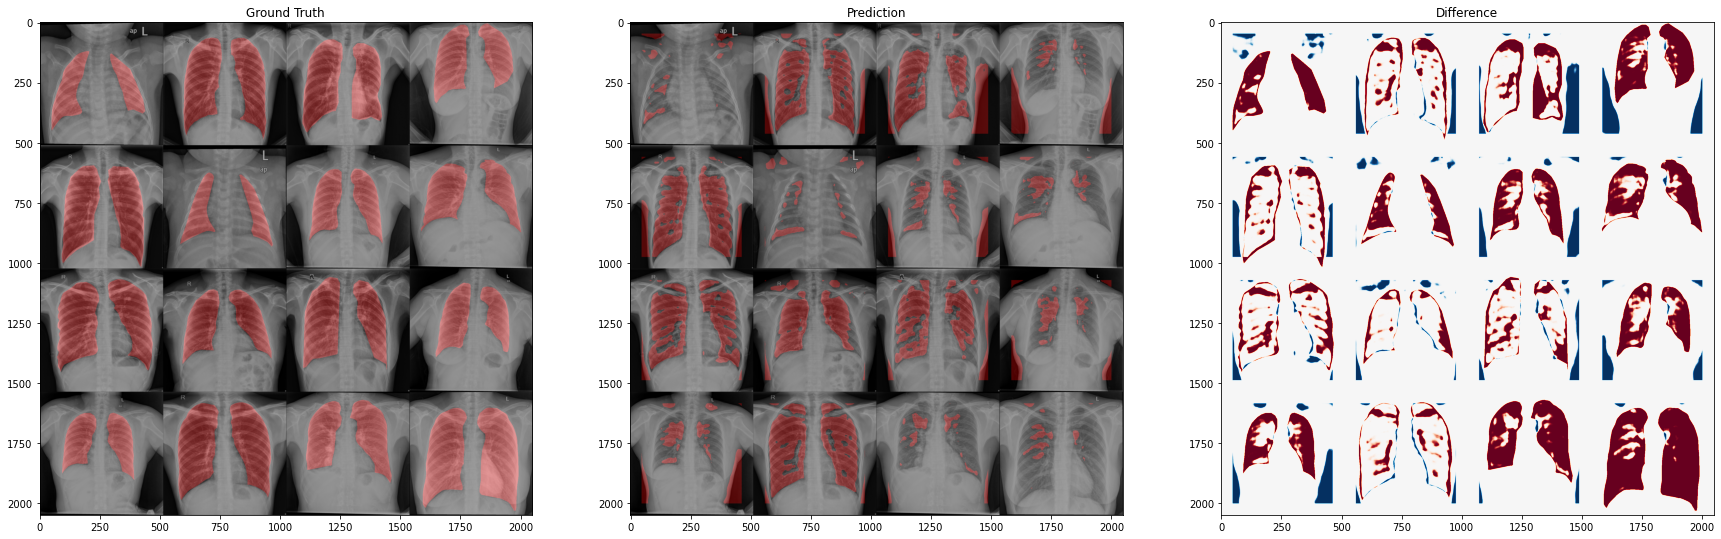

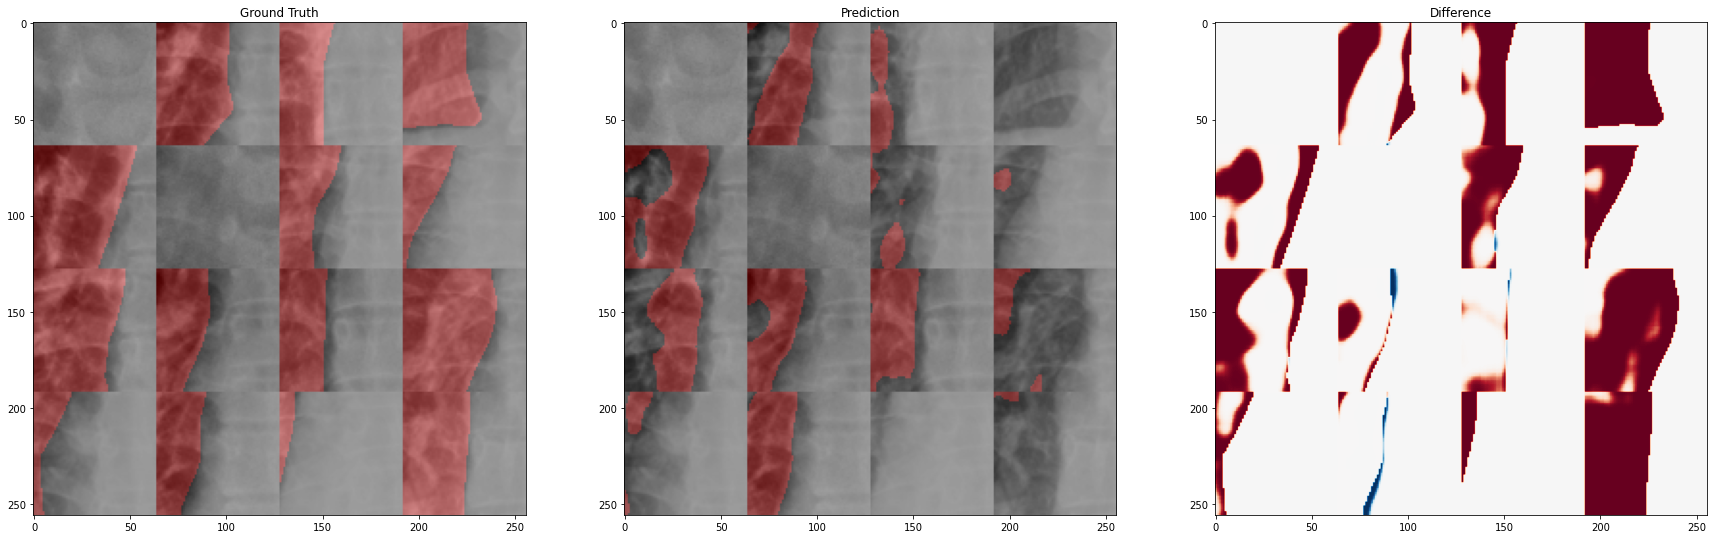

In [12]:
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
from skimage.util import montage as montage2d
from tensorflow.keras.metrics import BinaryAccuracy


def add_boundary(in_img, in_seg, cmap = 'bone', norm = True, add_labels = True):
    if norm:
        n_img = (1.0*in_img-in_img.min())/(1.1*(in_img.max()-in_img.min()))
    else:
        n_img = in_img
    rgb_img = plt.cm.get_cmap(cmap)(n_img)[:, :, :3]
    if add_labels:
        return label2rgb(image = rgb_img, label = in_seg.astype(int), bg_label = 0)
    else:
        return mark_boundaries(image = rgb_img, label_img = in_seg.astype(int), color = (0, 1, 0), mode = 'thick')
    
def show_full_st(in_img, in_seg, gt_seg):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
    out_mtg = add_boundary(montage2d(in_img[:, :, :, 0]), 
                           montage2d(gt_seg[:, :, :, 0]>0.5))
    ax1.imshow(out_mtg)
    ax1.set_title('Ground Truth')
    out_mtg = add_boundary(montage2d(in_img[:, :, :, 0]), 
                           montage2d(in_seg[:, :, :, 0]>0.5))
    ax2.imshow(out_mtg)
    ax2.set_title('Prediction')
    out_mtg = montage2d(in_seg[:, :, :, 0]-gt_seg[:, :, :, 0])
    ax3.imshow(out_mtg, cmap='RdBu', vmin=-1, vmax=1)
    ax3.set_title('Difference')
    
    m = BinaryAccuracy()
    m.update_state(gt_seg, in_seg)
    print(m.result().numpy())
    
def show_examples(n=1, with_roi = True):
    roi_func = lambda x: x[:, 
                               OUT_DIM[0]//2-32:OUT_DIM[0]//2+32,
                               OUT_DIM[1]//2-64:OUT_DIM[1]//2,
                               :
                              ]
    for (test_X, test_Y), _ in zip(val_gen, range(n)):
        seg_Y = net.predict(test_X)
        show_full_st(test_X, seg_Y, test_Y)
        show_full_st(roi_func(test_X), roi_func(seg_Y), roi_func(test_Y))

show_examples(1)